In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.1
numpy 1.17.2
pandas 0.25.1
sklearn 0.21.3
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing= fetch_california_housing()

In [3]:
from sklearn.model_selection import train_test_split

x_train_all,x_test,y_train_all,y_test = train_test_split(
    housing.data, housing.target, random_state =7)

x_train,x_valid,y_train,y_valid = train_test_split(
    x_train_all,y_train_all,random_state=11)

print(x_train_all.shape,y_train_all.shape)
print(x_train.shape,y_train.shape)
print(x_valid.shape,y_valid.shape)
print(x_test.shape,y_test.shape)

(15480, 8) (15480,)
(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.fit_transform(x_valid)
x_test_scaled = scaler.fit_transform(x_test)

In [5]:
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

In [6]:
# RandomizedSearchCV
# 1. 轉化為sklearn的model
# 2. 定義參數集合
# 3. 搜索參數


# learning_rate:[1e-4,3e-4,1e-3,3e-3,1e-2,3e-2]
# w = w + grad * learning_rate

learning_rates = [1e-4,3e-4,1e-3,3e-3,1e-2,3e-2]
histories = []

def build_model(hidden_layers=1,
                layer_size=30,
                learning_rate = 3e-3 ):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size,activation='relu',
                                input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers-1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse',optimizer = optimizer)
    
    return model



sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(
    build_model)

history = sklearn_model.fit(x_train_scaled,y_train,epochs =100,
                 validation_data = (x_valid_scaled,y_valid),
                 callbacks = callbacks)


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 42us/sample - loss: 1.5055 - val_loss: 1.1984
Epoch 2/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.9380 - val_loss: 0.6782
Epoch 3/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.6110 - val_loss: 0.6172
Epoch 4/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5651 - val_loss: 0.5720
Epoch 5/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5325 - val_loss: 0.5577
Epoch 6/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.5061 - val_loss: 0.5074
Epoch 7/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4876 - val_loss: 0.4889
Epoch 8/100
11610/11610 [==============================] - 0s 25us/sample - loss: 0.4739 - val_loss: 0.4788
Epoch 9/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.461

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

for lr,history in zip(learning_rates,histories):
    print("Learning_rate:",lr)
    plot_learning_curves(history)

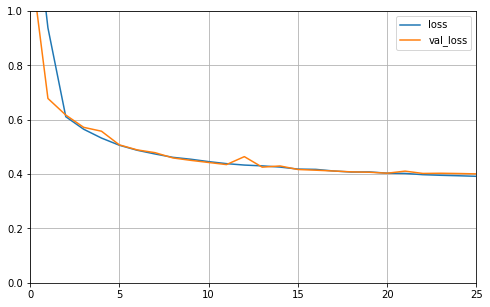

In [8]:
plot_learning_curves(history)

In [11]:
from scipy.stats import reciprocal

param_distribution = {
    "hidden_layers":[1,2,3,4],
    "layer_size" : np.arange(1,100),
    "learning_rate":reciprocal(1e-4,1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                   param_distribution,
                                   n_iter=10,
                                   n_jobs=1)

# cross_validation 機制

In [12]:
random_search_cv.fit(x_train_scaled,y_train,epochs =100,
                 validation_data = (x_valid_scaled,y_valid),
                 callbacks = callbacks)

Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 67us/sample - loss: 5.2442 - val_loss: 4.8105
Epoch 2/100
7740/7740 [==============================] - 0s 34us/sample - loss: 4.0866 - val_loss: 3.7736
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 3.1575 - val_loss: 2.9011
Epoch 4/100
7740/7740 [==============================] - 0s 35us/sample - loss: 2.3969 - val_loss: 2.2042
Epoch 5/100
7740/7740 [==============================] - 0s 34us/sample - loss: 1.8467 - val_loss: 1.7439
Epoch 6/100
7740/7740 [==============================] - 0s 34us/sample - loss: 1.4973 - val_loss: 1.4582
Epoch 7/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.2896 - val_loss: 1.2888
Epoch 8/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.1570 - val_loss: 1.1720
Epoch 9/100
7740/7740 [==============================] - 0s 39us/sample - loss: 1.0625 - val_loss: 1.085

7740/7740 [==============================] - 0s 64us/sample - loss: 5.0104 - val_loss: 4.7085
Epoch 2/100
7740/7740 [==============================] - 0s 40us/sample - loss: 4.0232 - val_loss: 3.7832
Epoch 3/100
7740/7740 [==============================] - 0s 34us/sample - loss: 3.1836 - val_loss: 2.9970
Epoch 4/100
7740/7740 [==============================] - 0s 35us/sample - loss: 2.4968 - val_loss: 2.3822
Epoch 5/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.9910 - val_loss: 1.9483
Epoch 6/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.6639 - val_loss: 1.6798
Epoch 7/100
7740/7740 [==============================] - 0s 33us/sample - loss: 1.4615 - val_loss: 1.5049
Epoch 8/100
7740/7740 [==============================] - 0s 34us/sample - loss: 1.3254 - val_loss: 1.3791
Epoch 9/100
7740/7740 [==============================] - 0s 36us/sample - loss: 1.2221 - val_loss: 1.2795
Epoch 10/100
7740/7740 [==============================] - 

7740/7740 [==============================] - 0s 33us/sample - loss: 0.8813 - val_loss: 0.9360
Epoch 13/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.8495 - val_loss: 0.9048
Epoch 14/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.8222 - val_loss: 0.8786
Epoch 15/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7987 - val_loss: 0.8554
Epoch 16/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7782 - val_loss: 0.8355
Epoch 17/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.7604 - val_loss: 0.8182
Epoch 18/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.7446 - val_loss: 0.8034
Epoch 19/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7312 - val_loss: 0.7902
Epoch 20/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.7195 - val_loss: 0.7786
Epoch 21/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 35us/sample - loss: 0.4885 - val_loss: 0.5361
Epoch 89/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4868 - val_loss: 0.5347
Epoch 90/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4851 - val_loss: 0.5326
Epoch 91/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4834 - val_loss: 0.5297
Epoch 92/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4816 - val_loss: 0.5271
Epoch 93/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4801 - val_loss: 0.5261
Epoch 94/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4784 - val_loss: 0.5235
Epoch 95/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4768 - val_loss: 0.5221
Epoch 96/100
3870/3870 [==============================] - 0s 16us/sample - loss: 0.5193
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740

7740/7740 [==============================] - 0s 34us/sample - loss: 0.4313 - val_loss: 0.4341
Epoch 28/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4284 - val_loss: 0.4287
Epoch 29/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4266 - val_loss: 0.4289
Epoch 30/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4241 - val_loss: 0.4241
Epoch 31/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4223 - val_loss: 0.4244
Epoch 32/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4198 - val_loss: 0.4186
Epoch 33/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4182 - val_loss: 0.4179
Epoch 34/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4160 - val_loss: 0.4172
Epoch 35/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4149 - val_loss: 0.4121
Epoch 36/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 38us/sample - loss: 0.3929 - val_loss: 0.4119
Epoch 35/100
3870/3870 [==============================] - 0s 14us/sample - loss: 0.4284
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 64us/sample - loss: 4.8830 - val_loss: 4.0790
Epoch 2/100
7740/7740 [==============================] - 0s 35us/sample - loss: 3.1348 - val_loss: 2.5751
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 1.9241 - val_loss: 1.5986
Epoch 4/100
7740/7740 [==============================] - 0s 36us/sample - loss: 1.2627 - val_loss: 1.1537
Epoch 5/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.9935 - val_loss: 0.9806
Epoch 6/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.8841 - val_loss: 0.9046
Epoch 7/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.8289 - val_loss: 0.8606
Epoch 8/100
7740/7740 [=====

7740/7740 [==============================] - 0s 47us/sample - loss: 0.5021 - val_loss: 0.5139
Epoch 75/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.5001 - val_loss: 0.5120
Epoch 76/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.4981 - val_loss: 0.5098
Epoch 77/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4961 - val_loss: 0.5075
Epoch 78/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4942 - val_loss: 0.5055
Epoch 79/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4921 - val_loss: 0.5024
Epoch 80/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4904 - val_loss: 0.5011
Epoch 81/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4885 - val_loss: 0.4993
Epoch 82/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.4866 - val_loss: 0.4967
Epoch 83/100
3870/3870 [==========================

7740/7740 [==============================] - 0s 39us/sample - loss: 0.4855 - val_loss: 0.5097
Epoch 67/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.4839 - val_loss: 0.5083
Epoch 68/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.4824 - val_loss: 0.5064
Epoch 69/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.4808 - val_loss: 0.5044
Epoch 70/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.4793 - val_loss: 0.5024
Epoch 71/100
3870/3870 [==============================] - 0s 18us/sample - loss: 0.4835
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 72us/sample - loss: 3.7888 - val_loss: 3.3187
Epoch 2/100
7740/7740 [==============================] - 0s 38us/sample - loss: 2.5383 - val_loss: 2.2024
Epoch 3/100
7740/7740 [==============================] - 0s 38us/sample - loss: 1.7036 - val_loss: 1.5644
Epoch 4/100
7740/7740 [=

7740/7740 [==============================] - 0s 35us/sample - loss: 0.4992 - val_loss: 0.5383
Epoch 71/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4972 - val_loss: 0.5356
Epoch 72/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4953 - val_loss: 0.5330
Epoch 73/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4934 - val_loss: 0.5308
Epoch 74/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4915 - val_loss: 0.5285
Epoch 75/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4896 - val_loss: 0.5266
Epoch 76/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4878 - val_loss: 0.5240
Epoch 77/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.4861 - val_loss: 0.5218
Epoch 78/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4843 - val_loss: 0.5195
Epoch 79/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 34us/sample - loss: 0.4803 - val_loss: 0.4852
Epoch 56/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.4782 - val_loss: 0.4821
Epoch 57/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4760 - val_loss: 0.4794
Epoch 58/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4737 - val_loss: 0.4764
Epoch 59/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4719 - val_loss: 0.4757
Epoch 60/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4701 - val_loss: 0.4736
Epoch 61/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.4681 - val_loss: 0.4702
Epoch 62/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4662 - val_loss: 0.4680
Epoch 63/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4644 - val_loss: 0.4666
Epoch 64/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 34us/sample - loss: 0.7782 - val_loss: 0.8229
Epoch 10/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.7285 - val_loss: 0.7798
Epoch 11/100
7740/7740 [==============================] - 0s 41us/sample - loss: 0.6918 - val_loss: 0.7460
Epoch 12/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.6644 - val_loss: 0.7214
Epoch 13/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.6434 - val_loss: 0.7020
Epoch 14/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6271 - val_loss: 0.6860
Epoch 15/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.6139 - val_loss: 0.6730
Epoch 16/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.6028 - val_loss: 0.6602
Epoch 17/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5934 - val_loss: 0.6502
Epoch 18/100
7740/7740 [==========================

3870/3870 [==============================] - 0s 15us/sample - loss: 0.3477
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 0s 57us/sample - loss: 1.3440 - val_loss: 0.7615
Epoch 2/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.6854 - val_loss: 0.5257
Epoch 3/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4884 - val_loss: 0.4638
Epoch 4/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4520 - val_loss: 0.4289
Epoch 5/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4235 - val_loss: 0.4207
Epoch 6/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4092 - val_loss: 0.3982
Epoch 7/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.3999 - val_loss: 0.3890
Epoch 8/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3935 - val_loss: 0.3993
Epoch 9/100
7740/7740 [======

7740/7740 [==============================] - 0s 34us/sample - loss: 0.3834 - val_loss: 0.3966
Epoch 16/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.3838 - val_loss: 0.3914
Epoch 17/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3791 - val_loss: 0.3907
Epoch 18/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.3770 - val_loss: 0.3908
Epoch 19/100
3870/3870 [==============================] - 0s 20us/sample - loss: 0.3678
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 66us/sample - loss: 1.4766 - val_loss: 8.0893
Epoch 2/100
7740/7740 [==============================] - 0s 37us/sample - loss: 2.2583 - val_loss: 0.6934
Epoch 3/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5173 - val_loss: 0.5157
Epoch 4/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.4473 - val_loss: 0.4641
Epoch 5/100
7740/7740 [==

7740/7740 [==============================] - 0s 36us/sample - loss: 0.5665 - val_loss: 0.6033
Epoch 5/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5337 - val_loss: 0.5718
Epoch 6/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.5150 - val_loss: 0.5498
Epoch 7/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.4944 - val_loss: 0.5290
Epoch 8/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4799 - val_loss: 0.5138
Epoch 9/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.4661 - val_loss: 0.4973
Epoch 10/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.4583 - val_loss: 0.4938
Epoch 11/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.4501 - val_loss: 0.4840
Epoch 12/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.4523 - val_loss: 0.4753
Epoch 13/100
7740/7740 [==============================]

7740/7740 [==============================] - 0s 38us/sample - loss: 0.5615 - val_loss: 0.5707
Epoch 50/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5586 - val_loss: 0.5674
Epoch 51/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5557 - val_loss: 0.5646
Epoch 52/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5529 - val_loss: 0.5614
Epoch 53/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5502 - val_loss: 0.5584
Epoch 54/100
7740/7740 [==============================] - 0s 38us/sample - loss: 0.5474 - val_loss: 0.5551
Epoch 55/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.5449 - val_loss: 0.5523
Epoch 56/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5423 - val_loss: 0.5498
Epoch 57/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5398 - val_loss: 0.5465
Epoch 58/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 37us/sample - loss: 0.5814 - val_loss: 0.6002
Epoch 51/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5782 - val_loss: 0.5973
Epoch 52/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5752 - val_loss: 0.5945
Epoch 53/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5722 - val_loss: 0.5917
Epoch 54/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5694 - val_loss: 0.5891
Epoch 55/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5666 - val_loss: 0.5863
Epoch 56/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5640 - val_loss: 0.5836
Epoch 57/100
7740/7740 [==============================] - 0s 36us/sample - loss: 0.5615 - val_loss: 0.5814
Epoch 58/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5590 - val_loss: 0.5791
Epoch 59/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 48us/sample - loss: 0.5720 - val_loss: 0.6204
Epoch 50/100
7740/7740 [==============================] - 0s 49us/sample - loss: 0.5687 - val_loss: 0.6170
Epoch 51/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5655 - val_loss: 0.6135
Epoch 52/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5624 - val_loss: 0.6101
Epoch 53/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.5594 - val_loss: 0.6066
Epoch 54/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5564 - val_loss: 0.6037
Epoch 55/100
7740/7740 [==============================] - 0s 37us/sample - loss: 0.5535 - val_loss: 0.6002
Epoch 56/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5506 - val_loss: 0.5973
Epoch 57/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5478 - val_loss: 0.5943
Epoch 58/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 39us/sample - loss: 0.6078 - val_loss: 0.6224
Epoch 37/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.6035 - val_loss: 0.6182
Epoch 38/100
7740/7740 [==============================] - 0s 35us/sample - loss: 0.5992 - val_loss: 0.6142
Epoch 39/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.5951 - val_loss: 0.6093
Epoch 40/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5913 - val_loss: 0.6057
Epoch 41/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5875 - val_loss: 0.6018
Epoch 42/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5839 - val_loss: 0.5980
Epoch 43/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.5803 - val_loss: 0.5939
Epoch 44/100
7740/7740 [==============================] - 0s 30us/sample - loss: 0.5769 - val_loss: 0.5903
Epoch 45/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 33us/sample - loss: 0.5608 - val_loss: 0.5811
Epoch 44/100
7740/7740 [==============================] - 0s 42us/sample - loss: 0.5585 - val_loss: 0.5789
Epoch 45/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5560 - val_loss: 0.5767
Epoch 46/100
7740/7740 [==============================] - 0s 40us/sample - loss: 0.5536 - val_loss: 0.5744
Epoch 47/100
7740/7740 [==============================] - 0s 43us/sample - loss: 0.5513 - val_loss: 0.5716
Epoch 48/100
7740/7740 [==============================] - 0s 32us/sample - loss: 0.5491 - val_loss: 0.5695
Epoch 49/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.5468 - val_loss: 0.5674
Epoch 50/100
7740/7740 [==============================] - 0s 45us/sample - loss: 0.5447 - val_loss: 0.5651
Epoch 51/100
7740/7740 [==============================] - 0s 44us/sample - loss: 0.5425 - val_loss: 0.5631
Epoch 52/100
7740/7740 [==========================

7740/7740 [==============================] - 0s 32us/sample - loss: 0.4768 - val_loss: 0.5128
Epoch 56/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4751 - val_loss: 0.5103
Epoch 57/100
7740/7740 [==============================] - 0s 31us/sample - loss: 0.4734 - val_loss: 0.5081
Epoch 58/100
7740/7740 [==============================] - 0s 29us/sample - loss: 0.4718 - val_loss: 0.5066
Epoch 59/100
7740/7740 [==============================] - 0s 28us/sample - loss: 0.4702 - val_loss: 0.5047
Epoch 60/100
3870/3870 [==============================] - 0s 13us/sample - loss: 0.5142
Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.7215 - val_loss: 0.5024
Epoch 2/100
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4484 - val_loss: 0.4265
Epoch 3/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4007 - val_loss: 0.3834
Epoch 4/100
11610

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1417ccd10>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 3...45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x142d5ff10>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train

In [14]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 4, 'layer_size': 96, 'learning_rate': 0.007378964074044724}
-0.33696053407245624


In [16]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled,y_test)

5160/5160 [==============================] - 0s 20us/sample - loss: 0.3701


0.37007715434067007